<a href="https://colab.research.google.com/github/dhyanshah/MS7333_QTW/blob/master/Case%2012/DC_DS_Unit12_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study 12: Higgs Boson Replica Neural Network




# Methods

The first 10.5 MM rows are trained and validated with a 9:1 ratio and the last 500 rows are tested for accuracy, precision, recall and ROC score metrics, unlike the classification models we ran previously. With the use of tools such as Tensorflow, we can optimize parameters for number of layers, neurons (units), activation function, batch size, kernel initializer, optimizer, learning rate, epsilon, decay rate, and dropout rate. With these optimized parameters, the final model will expand the the number of default epochs from 20 to 500 with early stopping to find the highest ROC score. 

To give a little more detail on the parameters we are looking to optimize, see below:

* No. of Layers - While a single layer can be used to learn problems, utilizing multiple layers allows us to ease the process of our models learning using multilayer perceptrons. 
* No. of Neurons - like layers, add to the complexity of a model in helping it learn
* Activation Function - part of a node that defines the output of that node given a set of inputs. 
* Batch Size - number of training examples in one forward/backward pass
* Kernel Initializer - define the way to set the initial random weights of keras layers
* Optimizer - one of two artguments required for compiling a keras module
* Learning Rate - a function that takes an epoch index and current learning rate (float) as inputs and returns a new learning rate
* Epsilon - the value of the fuzz factor used in numeric expression
* Decay Rate - reducing an amount by a consistent peercentage rate over a period of time. 
* Dropout Rate - excluding random inputs from each update cycle to ensure optimization. 

Model replication would require the following base parameters for the nueral network.
* Normalization Method = Standardized between 0 and 1 
* Neurons = 300 
* Layers = 5
* Activation (Layer 1-4) = tanh 
* Activation (Layer 5) = sigmoid
* Optimizer = Stochastic Gradient Descent
* Learning Rate = 0.05
* Learning Rate Decay = 1e-5 
* Learning Rate Minimum = 0.000001
* Momentum = .9 to .99
* Loss = MSE
* Metrics = AUC
* Epochs = 1000 
* Batch size = 100 

In [ ]:
#pip install tensorflow

In [ ]:
%matplotlib inline

import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.ABOVE_NORMAL_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
from pprint import pprint
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from google.colab import drive


# in order to have reproducible result
from numpy.random import seed
import tensorflow
tensorflow.random.set_seed(2)


We have implemented the get_metrics function that will retrive the current model's ROC, accuracy, precision, recall and F1-score metrics for the test dataset. 

We will build a net functiont hat will set the default parameters for a neural network if undefined in the code. This means we would move forward with a dropout of 0.1, activations is relu, uniform initializer, stochastic gradient descent optimizer, 0.1 learning rate, 1e-6 learning decay, 0.9 momentum, Nesterov method, 5000 batch size, and patience of 2 where accuracy and binary cross entropy loss functions are monitored for the training and validation datasets. 

Setting the default parameters in the train function will include an early stopping to find accuracy and validation accuracy of the current neural network per epoch for the training and validation datasets. 

In [ ]:
def get_metrics(y_true, y_pred, treshhold=.5):
    RocAuc=metrics.roc_auc_score(y_test, y_pred)
    y_pred = (y_pred > treshhold).astype(np.int32)
    return dict(
        RocAuc="{:.4f}".format(metrics.roc_auc_score(y_test, y_pred)),
        Accuracy="{:.4f}".format(metrics.accuracy_score(y_test, y_pred)),
        Precision="{:.4f}".format(metrics.precision_score(y_test, y_pred)),
        Recall="{:.4f}".format(metrics.recall_score(y_test, y_pred)),
        F1="{:.4f}".format(metrics.f1_score(y_test, y_pred))
    )

def net(units,
        dropouts=.1,
        activations=None,
        kernel_initializers='uniform',
        optimizer=None
    ):

    input_dim = x.shape[1]
    assert type(units) == list and len(units) and units[-1] == 1
    units = units[:]
    if activations == None:
        activations = ['relu' for _ in units]
        activations[-1] = 'sigmoid'
    activations = activations[:]
    if type(dropouts) != list:
        dropouts = [dropouts for _ in range(len(units)-1)]
    dropouts = dropouts[:]
    if type(kernel_initializers) != list:
        kernel_initializers = [kernel_initializers for _ in units]
    kernel_initializers = kernel_initializers[:]
    assert len(units) == len(kernel_initializers) == len(activations) == len(dropouts)+1
    if optimizer is None:
        optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        
    model = Sequential()
    
    # first layer is special so it is out of the loop
    unit = units.pop(0)
    activation = activations.pop(0)
    try:
        dropout = dropouts.pop(0)
    except:
        dropout = 0.
    kernel_initializer = kernel_initializers.pop(0)
    
    model.add(Dense(unit, input_dim=input_dim, kernel_initializer=kernel_initializer))
    if activation:
        model.add(Activation(activation))
    if dropout:
        model.add(Dropout(dropout))
    
    for unit in units:
        activation = activations.pop(0)
        try:
            dropout = dropouts.pop(0)
        except:
            dropout = 0.
        kernel_initializer = kernel_initializers.pop(0)
        
        model.add(Dense(unit, kernel_initializer=kernel_initializer))
        if activation:
            model.add(Activation(activation))
        if dropout:
            model.add(Dropout(dropout))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

default_epochs = 20

def train(model, epochs=default_epochs, batch_size=5000, checkpoint=False, patience=2):
    history = keras.callbacks.History()
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=patience,
        verbose=0,
        mode='auto')
    
    callbacks = [history, early_stop]
    
    if checkpoint:
        filepath="weights.best.hdf5"
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath='best.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks.append(checkpoint)
    
    model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=.1)
    result = pd.DataFrame(history.history)
    del result['loss']
    del result['val_loss']
    result = result.rename(columns={
        'acc': 'Train Accuracy',
        'val_acc': 'Validation Accuracy',
        'loss': 'Train Loss',
        'val_loss': 'Validation Loss',
    })
    index = pd.Index(np.arange(epochs), name='Epoch')
    result.reindex(index)
    result.index += 1
    result.index.name = 'Epoch'
    result.columns.name = 'Accuracy'
    return result

## Results

To help with the computing power with regards to the size of the dataset, we converted our default imported float64 values to the float16 to make in-core memory usage more efficient. Our table below shows how float16 will maintain data integrity while reducing the memory to 608.4 MB. 

In [ ]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
#!gunzip *.gz

data=pd.read_csv("HIGGS.csv",header=None, dtype=np.float64, engine='c')
data.columns=['label','lepton pt','lepton eta','lepton phi','missing energy magnitude','missing energy phi',
              'jet 1 pt','jet 1 eta','jet 1 phi','jet 1 b-tag','jet 2 pt','jet 2 eta','jet 2 phi','jet 2 b-tag',
              'jet 3 pt','jet 3 eta','jet 3 phi','jet 3 b-tag','jet 4 pt','jet 4 eta','jet 4 phi','jet 4 b-tag',
              'm_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb']

data1 = data.max()-data.min()
data=data.astype('float16')
data.info()

In [ ]:
#!pip install pandas-profiling==2.7.1
#conda install -c conda-forge/label/cf202003 pandas-profiling

In [ ]:
data2 = data.max()-data.min()

#memory = pd.concat([data1, data2], axis=1, join_axes=[data1.index])
memory = pd.concat([data1, data2], axis=1)
memory.columns=['Before','After']
print('Table 1: Data Min and Max from Float64 to Float16')
memory

Table 1: Data Min and Max from Float64 to Float16


,Before,After
label,1.000000,1.000000
lepton pt,11.824217,11.828125
lepton eta,4.869844,4.871094
lepton phi,3.485744,3.484375
missing energy magnitude,15.396584,15.398438
missing energy phi,3.487201,3.488281
jet 1 pt,9.802888,9.796875
jet 1 eta,5.939399,5.937500
jet 1 phi,3.482691,3.482422
jet 1 b-tag,2.173076,2.173828


## Table 1: Float 16 still preserves the data integrity compared to that of float64

We plotted all 28 varlables to see how the distrubtions of numerical and categrotical variables to see how much loss we had to the data from converting to a float64 to a float16. Here, we can see that the loss is minimal. 



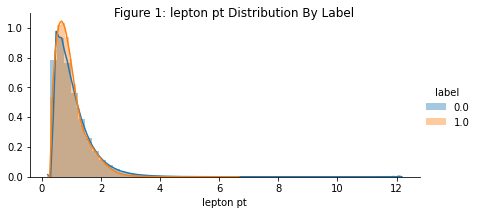

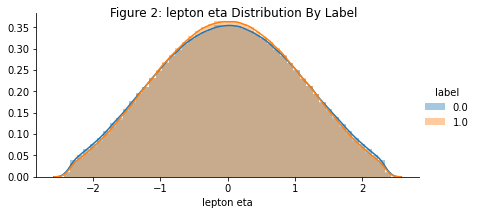

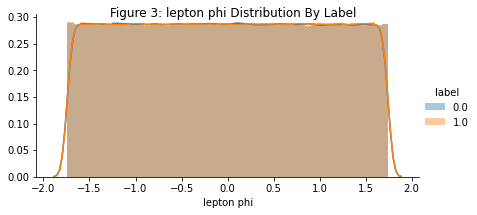

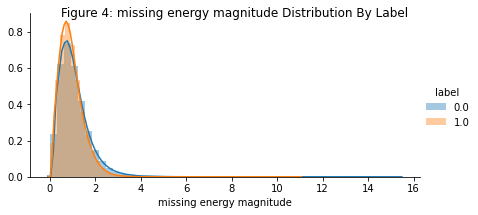

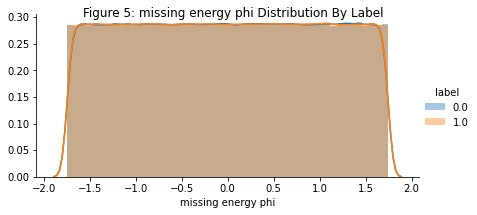

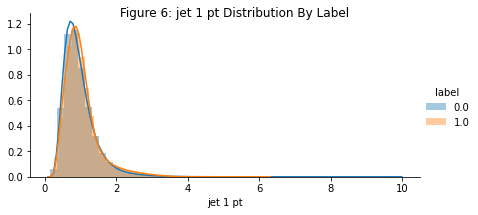

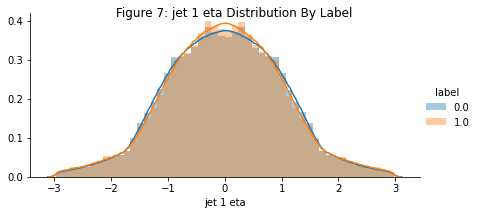

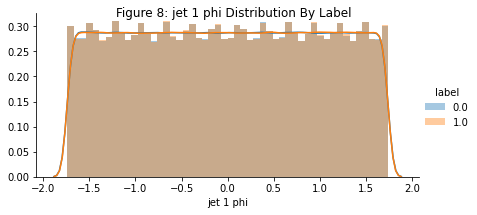

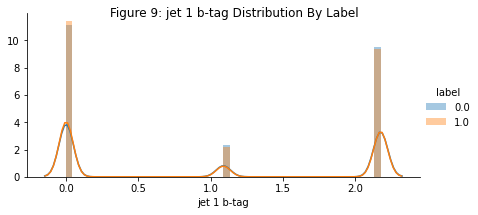

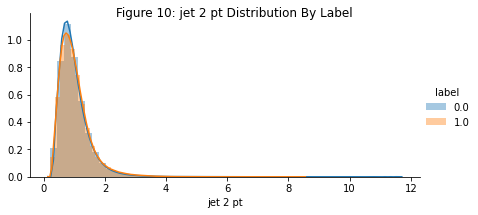

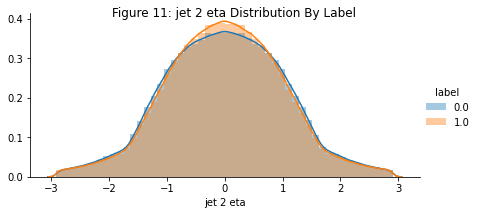

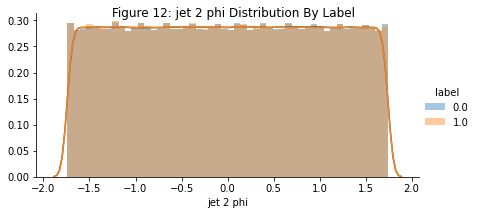

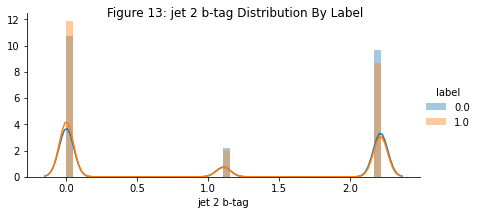

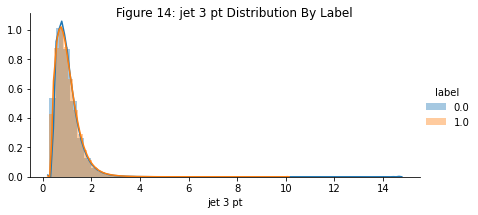

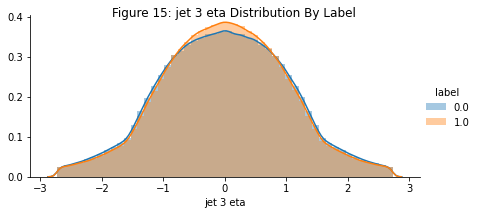

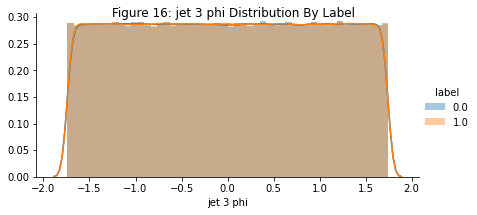

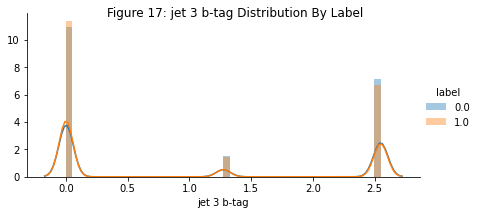

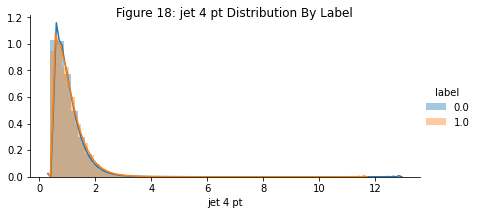

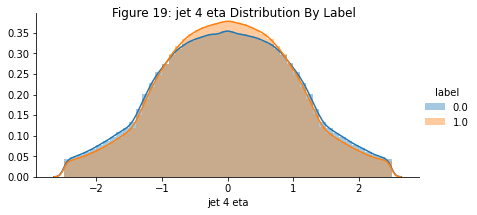

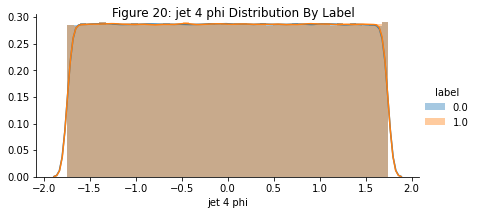

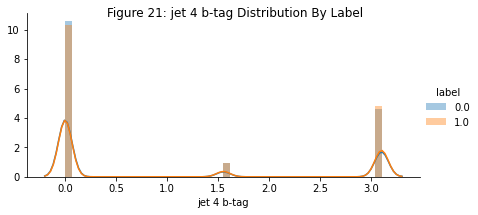

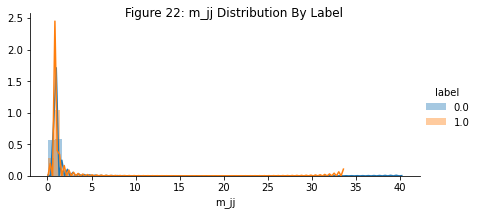

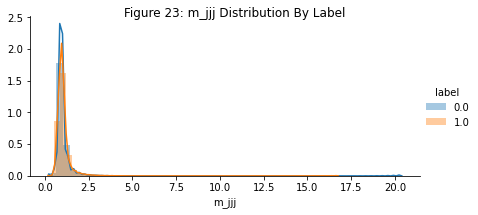

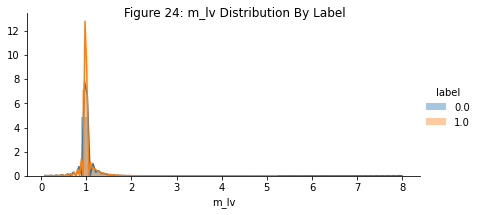

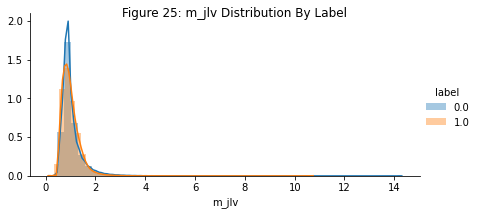

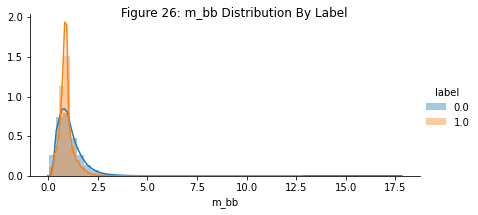

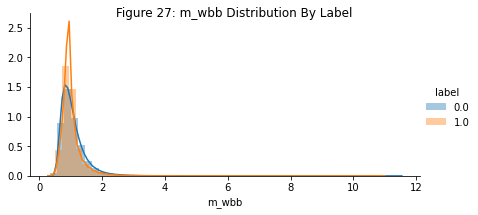

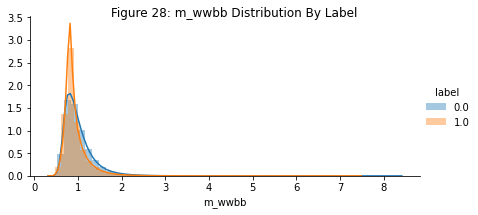

In [ ]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(data.columns.values)
for i in colnames[1:]:
    facet = sns.FacetGrid(data, hue='label',aspect=2).set_titles(i)
    facet.map(sns.distplot,i)
    facet.add_legend()
    Title=str(["Figure ",colnames.index(i),": ",i," Distribution By Label"])
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i),": ",i," Distribution By Label"]))))
    plt.show()

In figure 1 through 28, we an see that we have an array of normal and skewed distributions between each of our varaibles at play. There were thirteen variables that have shown outlier present. 

Next, let's look at a heatmap of correlations between variables and the Higgs Boson label. The only positive correlation as well as the last 7 derivative kinematic variables which show strong long relations. 

[Figure 29]

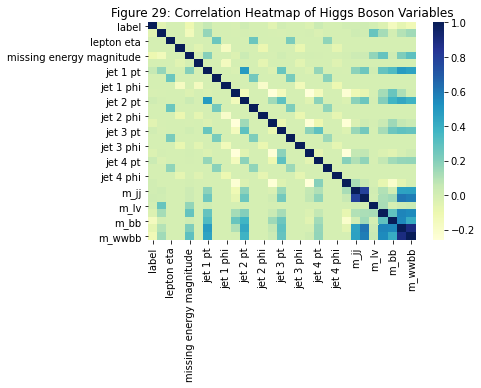

In [ ]:
ax = plt.axes()
sns.heatmap(data.corr(), cmap="YlGnBu", ax = ax)
ax.set_title('Figure 29: Correlation Heatmap of Higgs Boson Variables')
plt.show()

Figure 29: Most variables are weekly correlated with the Higgs Boson Label for the last 7 variables having any real correlation. 

We will now split our training and testing datasets into the target and predictor variables at y and x. This will balance our target variable at .05 so that we can choose accuracy as the target metric. 

In [ ]:
# labels must be 0 or 1 and not in between
assert not ((data["label"]>0)&(data["label"]<1)).sum()
data["label"] = data["label"].astype(np.int16)

test_data = data.iloc[-500000:].copy()
data = data.iloc[:-500000]

y = np.array(data.iloc[:,0])
x = np.array(data.iloc[:,1:])

x_test = np.array(test_data.iloc[:,1:])
y_test = np.array(test_data.iloc[:,0])

del test_data, data
y.mean()

0.5299634285714285

The ROC accuracy of our baseline layer and neuron count shows a 0.5 with a high recall, which explains the impact to the F1 score. 

In [ ]:
model = net([1])
print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Test Dataset : {'RocAuc': '0.4979', 'Accuracy': '0.5195', 'Precision': '0.5278', 'Recall': '0.8696', 'F1': '0.6569'}


## 1. Pick 3 or more different architectures (add/subtract layers + neurons) and run the model + score. 

### Number of Layers Search

The default activation is relu to optimize the layers of our neural nethwork by way of the sigmoid having vanishing gradients that do not work well as relu or elu. We will incomroporate 50 neurons to optimize for layers. 

In [ ]:
hparams = []
for layers in range(1,5):
    hparams.append(
        dict(units=[50]*layers+[1])
    )
print('Testing Hyperparameters:')
pprint(hparams)

trainAcc_layers = {}
valAcc_layers = {}

Testing Hyperparameters:
[{'units': [50, 1]},
 {'units': [50, 50, 1]},
 {'units': [50, 50, 50, 1]},
 {'units': [50, 50, 50, 50, 1]}]


In [ ]:
hparams = []
for layers in range(1,5):
    hparams.append(
        dict(units=[50]*layers+[1])
    )
print('Testing Hyperparameters:')
pprint(hparams)

trainAcc_layers = {}
valAcc_layers = {}

for hparam in hparams:
    title = "Hyper Params: %s" % str(hparam)
    print(title)
    model = net(**hparam)
    result = train(model)
    trainAcc_layers[title] = result['accuracy']
    valAcc_layers[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Testing Hyperparameters:
[{'units': [50, 1]},
 {'units': [50, 50, 1]},
 {'units': [50, 50, 50, 1]},
 {'units': [50, 50, 50, 50, 1]}]
Hyper Params: {'units': [50, 1]}
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/20
9450000/9450000 [==============================] - 19s 2us/step - loss: 0.6024 - accuracy: 0.6729 - val_loss: 0.5718 - val_accuracy: 0.7058
Epoch 2/20
9450000/9450000 [==============================] - 19s 2us/step - loss: 0.5731 - accuracy: 0.7020 - val_loss: 0.5576 - val_accuracy: 0.7154
Epoch 3/20
9450000/9450000 [==============================] - 19s 2us/step - loss: 0.5653 - accuracy: 0.7083 - val_loss: 0.5545 - val_accuracy: 0.7200
Epoch 4/20
9450000/9450000 [==============================] - 19s 2us/step - loss: 0.5621 - accuracy: 0.7110 - val_loss: 0.5505 - val_accuracy: 0.7210
Epoch 5/20
9450000/9450000 [==============================] - 19s 2us/step - loss: 0.5600 - accuracy: 0.7126 - val_loss: 0.5481 - val_accuracy: 0.7218
Epoch 6/20
9450000/945000

### Layers Search Result

The accuracy increases as more layers are added across the 20 epochs we are using. Using 3 layers of 50 neurons, we saw that there's overfitting int he 4th layer where accuracy stopped as the model failed to continue learning from the training set [fig 30]. Therefore, the best number of layers is 3 with an accuracy of 0.7422 and the validation accuracy of 0.7519.

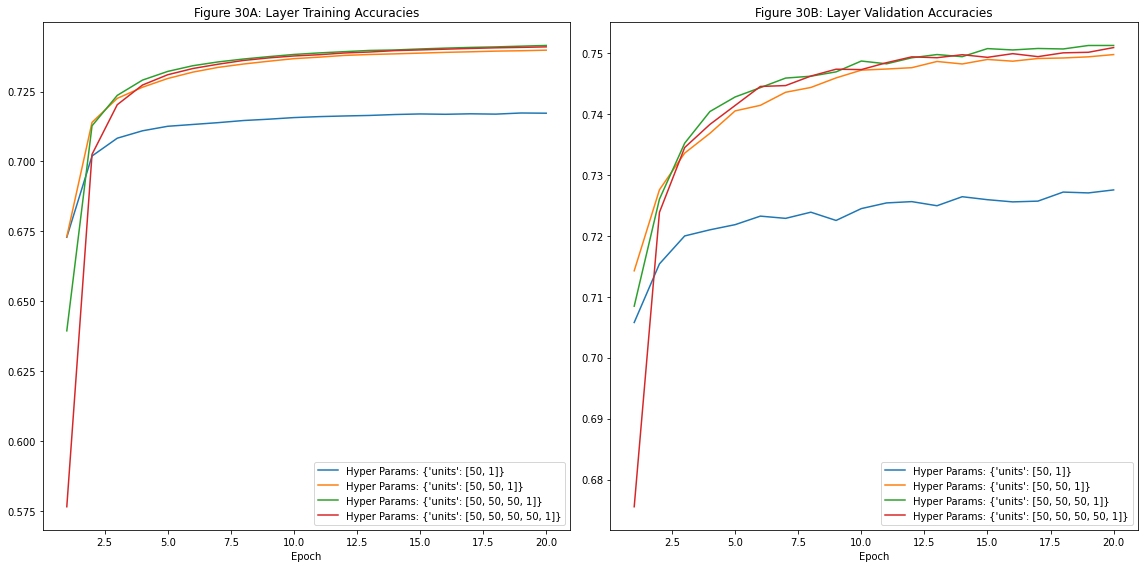

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_layers).plot(title='Figure 30A: Layer Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_layers).plot(title='Figure 30B: Layer Validation Accuracies', ax=axes[1])
plt.tight_layout()

In [ ]:
best_n_layers = 3

### Number of Neurons 

We will use the 3 layers we had success with in our previous model, and increase the number of neurons for each layer. We will increase by the same number of neurons to optimize for accuracy and F1 score. 

In [ ]:
hparams = []

for units in [100, 200, 400, 800]:
    hparams.append(
        dict(units=[units]*best_n_layers+[1])
    )
    
print('Testing Hyperparameters:')
pprint(hparams)

trainAcc_dense = {}
valAcc_dense = {}

for hparam in hparams:
    title = "Hyperparameters: %s" % str(hparam)
    print(title)
    
    model = net(**hparam)
    result = train(model, epochs=5)
    trainAcc_dense[title] = result['accuracy']
    valAcc_dense[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Testing Hyperparameters:
[{'units': [100, 100, 100, 1]},
 {'units': [200, 200, 200, 1]},
 {'units': [400, 400, 400, 1]},
 {'units': [800, 800, 800, 1]}]
Hyperparameters: {'units': [100, 100, 100, 1]}
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.5985 - accuracy: 0.6669 - val_loss: 0.5473 - val_accuracy: 0.7183
Epoch 2/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.5417 - accuracy: 0.7223 - val_loss: 0.5231 - val_accuracy: 0.7346
Epoch 3/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.5218 - accuracy: 0.7358 - val_loss: 0.5047 - val_accuracy: 0.7478
Epoch 4/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.5135 - accuracy: 0.7415 - val_loss: 0.4985 - val_accuracy: 0.7510
Epoch 5/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.5092 - accuracy: 0.7443 - val_loss: 0.5006 - val_accuracy: 0.7

### Number of neurons search result

Accuracy and F1-Score are the highest in the batch of 800 neurons per layer with an accuracy maxing out at 0.7602 [Fig. 31]. The time spent to run each batch increased up to 800 over 33% longer, so we will set to 100 neurons moving forward to save time to allow us to optimize the parameters to the final model. 

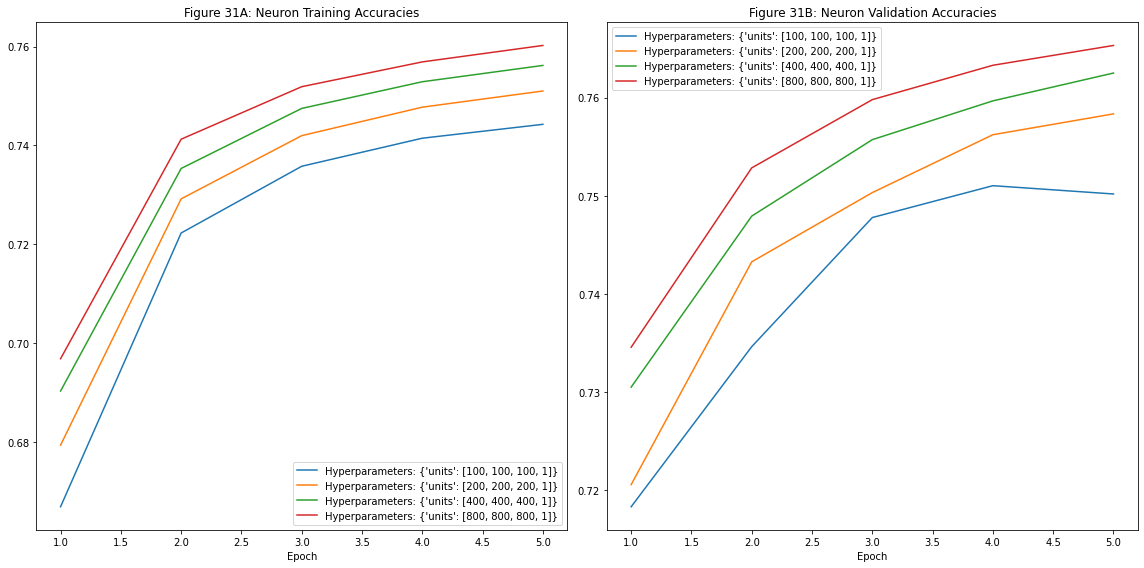

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_dense).plot(title='Figure 31A: Neuron Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_dense).plot(title='Figure 31B: Neuron Validation Accuracies', ax=axes[1])
plt.tight_layout()

### Fig. 31: The most accurate number of neurons is 800 with a training accuracy of 0.760 and a validation accuracy of 0.766.

In [ ]:
#still 800, reduced to 100 to save time and processing
best_n_units = 100

## 2. With those 3 architectures, we can run the same architecture with 2 different sigmoid activation functions. 

### Activations Search

The default optimization activation is relu for classification because sigmoid and tanh have vanishing gradients that do not work as well as relu or elu on deeper networks. 

In [ ]:
hparams = []
for activation in ['elu', 'relu', 'selu']:
    hparams.append(
        dict(
            units=[best_n_units]*best_n_layers+[1],
            activations=[activation]*best_n_layers+['sigmoid'],
        )
    )

print('Testing Hyperparameters:')
pprint(hparams)

trainAcc_activation = {}
valAcc_activation = {}

for hparam in hparams:
    title = "Hyperparameters: %s" % str(hparam)
    print(title)
    model = net(**hparam)
    result = train(model, epochs=5)
    trainAcc_activation[title] = result['accuracy']
    valAcc_activation[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Testing Hyperparameters:
[{'activations': ['elu', 'elu', 'elu', 'sigmoid'], 'units': [100, 100, 100, 1]},
 {'activations': ['relu', 'relu', 'relu', 'sigmoid'],
  'units': [100, 100, 100, 1]},
 {'activations': ['selu', 'selu', 'selu', 'sigmoid'],
  'units': [100, 100, 100, 1]}]
Hyperparameters: {'units': [100, 100, 100, 1], 'activations': ['elu', 'elu', 'elu', 'sigmoid']}
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.6275 - accuracy: 0.6443 - val_loss: 0.5925 - val_accuracy: 0.6817
Epoch 2/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.5880 - accuracy: 0.6855 - val_loss: 0.5703 - val_accuracy: 0.7002
Epoch 3/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.5718 - accuracy: 0.6989 - val_loss: 0.5597 - val_accuracy: 0.7089
Epoch 4/5
9450000/9450000 [==============================] - 25s 3us/step - loss: 0.5633 - accuracy: 0.7055 - val_loss: 0.

### Activations Search Result

Relu proved to be the most accurate function with a training set accuracy of 0.74 with a validation test accuracy of 0.75.

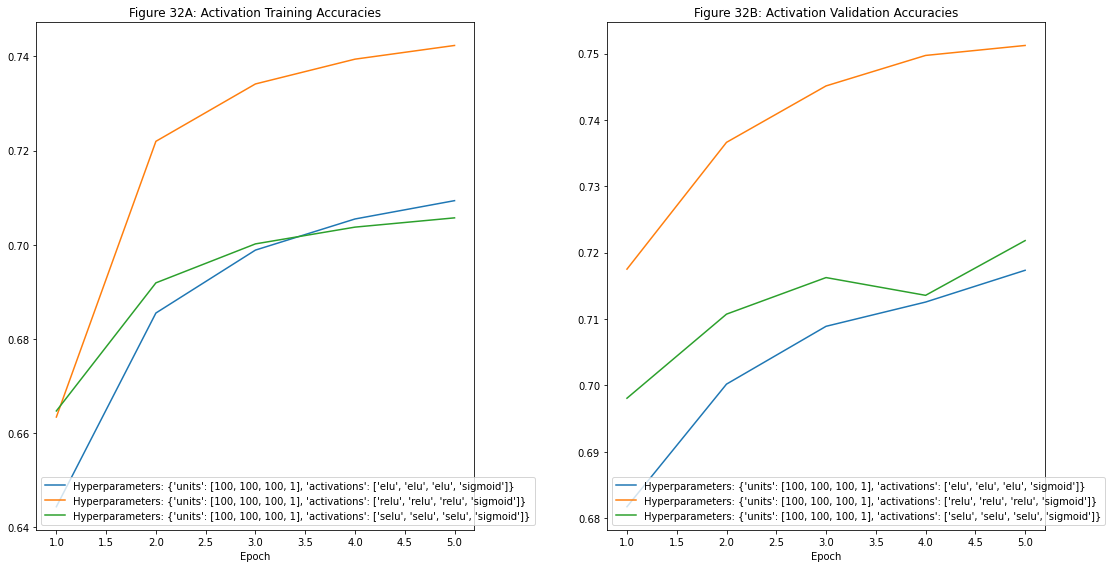

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_activation).plot(title='Figure 32A: Activation Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_activation).plot(title='Figure 32B: Activation Validation Accuracies', ax=axes[1])
plt.tight_layout()

### Figure 32: Relu is the best activation function by far as opposed to elu and selu. 

In [ ]:
best_activation = 'relu'

### 3. Take the best model from 1 and 2 and vary the batch size by at least 2 orders of magnitude. 

#### Batch Size Search

Let's range our batch sizes from 500 to 5000 to see where we are getting our best validation accuracy.

In [ ]:
best_hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
)

trainAcc_batch = {}
valAcc_batch = {}

for batch_size in 500, 1000, 50000:
    title = "Batch Size: %d" % batch_size
    print(title)
    model = net(**best_hparam)
    result = train(model, batch_size=batch_size, epochs=10)
    trainAcc_batch[title] = result['accuracy']
    valAcc_batch[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Batch Size: 500
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/10
9450000/9450000 [==============================] - 99s 10us/step - loss: 0.5506 - accuracy: 0.7138 - val_loss: 0.5167 - val_accuracy: 0.7397
Epoch 2/10
9450000/9450000 [==============================] - 100s 11us/step - loss: 0.5186 - accuracy: 0.7385 - val_loss: 0.5038 - val_accuracy: 0.7490
Epoch 3/10
9450000/9450000 [==============================] - 96s 10us/step - loss: 0.5116 - accuracy: 0.7434 - val_loss: 0.4971 - val_accuracy: 0.7528
Epoch 4/10
9450000/9450000 [==============================] - 97s 10us/step - loss: 0.5080 - accuracy: 0.7459 - val_loss: 0.4956 - val_accuracy: 0.7554
Epoch 5/10
9450000/9450000 [==============================] - 98s 10us/step - loss: 0.5058 - accuracy: 0.7474 - val_loss: 0.4915 - val_accuracy: 0.7564
Epoch 6/10
9450000/9450000 [==============================] - 96s 10us/step - loss: 0.5041 - accuracy: 0.7484 - val_loss: 0.4910 - val_accuracy: 0.7573
Epoch 7/10
945000

### Batch Size Search Result

The batch size of 1000 had the strongest training set accuracy of 0.75 and a validation accuracy of 0.76.

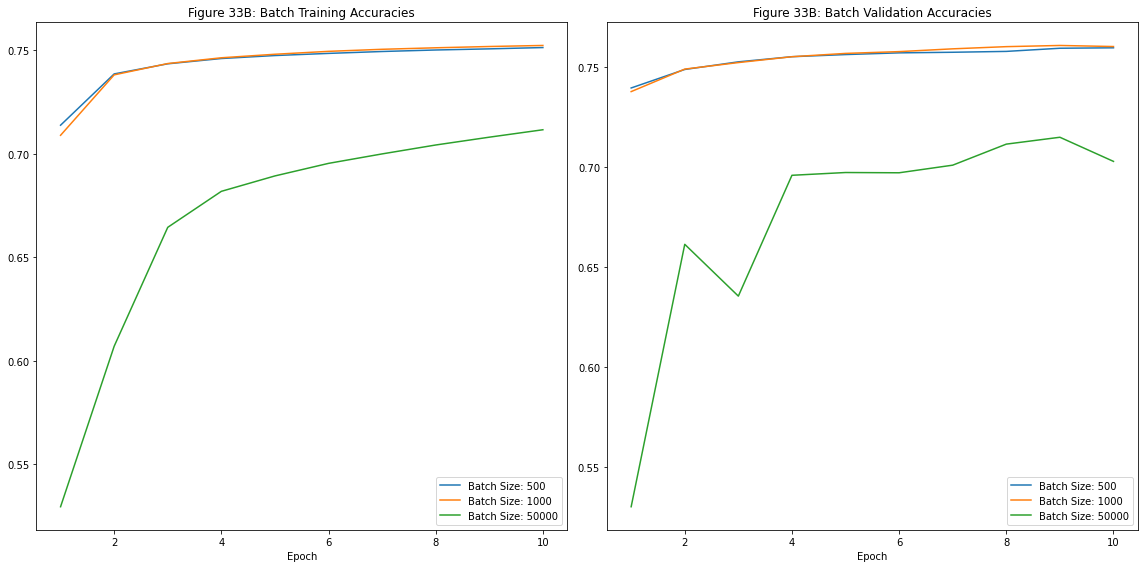

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_batch).plot(title='Figure 33B: Batch Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_batch).plot(title='Figure 33B: Batch Validation Accuracies', ax=axes[1])
plt.tight_layout()

#### Figure 33: A batch size of 1000 gives us the highest accuracy set and validation accuacy. 

In [ ]:
best_batch_size = 1000

### Take our best models (based on scores) from parts 1 and 2 and use 3 different kernel initializers with a reasonable batch size (to keep computation costs low).

#### Kernel Initializer  Search

Initializers for classification models perform better when we have normal distributions in our variables rather than uniform distributions. So we will only focus on initializers with normal distrubtions as well as variance scaling and orthogonal. 

In [ ]:
best_hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
)

trainAcc_initial = {}
valAcc_initial = {}

for kernel_initializer in ['VarianceScaling','orthogonal','random_normal','truncated_normal',
                           'glorot_normal','lecun_normal','he_normal']:
    title = "Kernel Initializers: %s" % kernel_initializer
    best_hparam['kernel_initializers'] = kernel_initializer
    print(title)
    
    model = net(**best_hparam)
    result = train(model, batch_size=best_batch_size, epochs=10)
    trainAcc_initial[title] = result['accuracy']
    valAcc_initial[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Kernel Initializers: VarianceScaling
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/10
9450000/9450000 [==============================] - 56s 6us/step - loss: 0.5546 - accuracy: 0.7108 - val_loss: 0.5126 - val_accuracy: 0.7425
Epoch 2/10
9450000/9450000 [==============================] - 55s 6us/step - loss: 0.5209 - accuracy: 0.7367 - val_loss: 0.5043 - val_accuracy: 0.7480
Epoch 3/10
9450000/9450000 [==============================] - 56s 6us/step - loss: 0.5130 - accuracy: 0.7421 - val_loss: 0.4957 - val_accuracy: 0.7537
Epoch 4/10
9450000/9450000 [==============================] - 55s 6us/step - loss: 0.5088 - accuracy: 0.7448 - val_loss: 0.4933 - val_accuracy: 0.7558
Epoch 5/10
9450000/9450000 [==============================] - 55s 6us/step - loss: 0.5064 - accuracy: 0.7467 - val_loss: 0.4904 - val_accuracy: 0.7573
Epoch 6/10
9450000/9450000 [==============================] - 56s 6us/step - loss: 0.5044 - accuracy: 0.7479 - val_loss: 0.4896 - val_accuracy: 0.7577
Epo

### Kernel Initializer Search Result

The random normal initializer is the best with a training accuracy of 0.7619 and a validation accuracy of 0.7613 in Figure 34

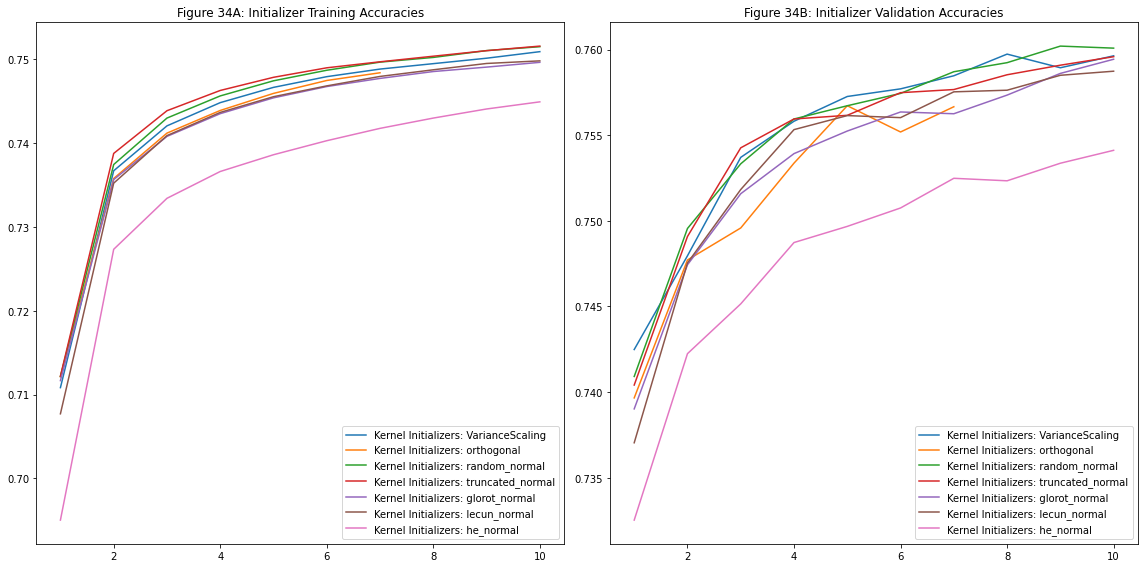

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_initial).plot(title='Figure 34A: Initializer Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_initial).plot(title='Figure 34B: Initializer Validation Accuracies', ax=axes[1])
plt.tight_layout()

#### Figure 34: The Random Normal Initializer is the best with a training accuacy of 0.7619 and a validation accuracy of 0.7613

In [ ]:
best_kernel_initializer = 'random_normal'

### Take your best 3 results from number 3 and try 3 different optimizers. 

#### Optimizers Search

We will use the default learning rates of the optimizers and see how they are optimized differently. 


In [ ]:
hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
    kernel_initializers=best_kernel_initializer
)

optimizers = dict(
    SGD=keras.optimizers.SGD(lr=.01, momentum=0.9, nesterov=True),
    Adagrad=keras.optimizers.Adagrad(),
    Adamax=keras.optimizers.Adamax(),
    Nadam=keras.optimizers.Nadam(),
    RMSprop=keras.optimizers.RMSprop(),
    Adadelta=keras.optimizers.Adadelta()
)

trainAcc_optimizer = {}
valAcc_optimizer = {}

for optimizer_name in optimizers:
    title = "Optimizer: %s" % optimizer_name
    print(optimizer_name)
    
    model = net(**hparam, optimizer=optimizers[optimizer_name])
    result = train(model, batch_size=best_batch_size, epochs=10)
    trainAcc_optimizer[title] = result['accuracy']
    valAcc_optimizer[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

SGD
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/10
9450000/9450000 [==============================] - 56s 6us/step - loss: 0.5960 - accuracy: 0.6707 - val_loss: 0.5450 - val_accuracy: 0.7194
Epoch 2/10
9450000/9450000 [==============================] - 57s 6us/step - loss: 0.5437 - accuracy: 0.7206 - val_loss: 0.5261 - val_accuracy: 0.7335
Epoch 3/10
9450000/9450000 [==============================] - 55s 6us/step - loss: 0.5301 - accuracy: 0.7302 - val_loss: 0.5140 - val_accuracy: 0.7423
Epoch 4/10
9450000/9450000 [==============================] - 56s 6us/step - loss: 0.5223 - accuracy: 0.7357 - val_loss: 0.5085 - val_accuracy: 0.7447
Epoch 5/10
9450000/9450000 [==============================] - 56s 6us/step - loss: 0.5173 - accuracy: 0.7390 - val_loss: 0.5041 - val_accuracy: 0.7484
Epoch 6/10
9450000/9450000 [==============================] - 56s 6us/step - loss: 0.5137 - accuracy: 0.7414 - val_loss: 0.5009 - val_accuracy: 0.7509
Epoch 7/10
9450000/9450000 [========

#### Optimizers Search Result

The optimizer Adamax is the best performer with the taraining accuracy of 0.7617 and a validation accuracy of 0.7606.

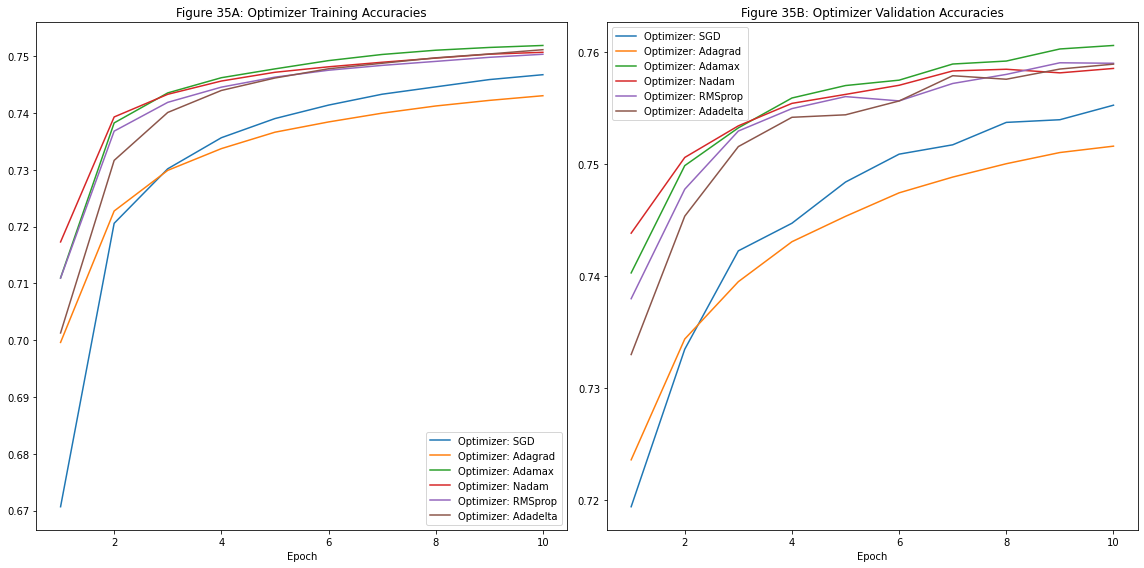

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_optimizer).plot(title='Figure 35A: Optimizer Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_optimizer).plot(title='Figure 35B: Optimizer Validation Accuracies', ax=axes[1])
plt.tight_layout()

#### Figure 35: The Accuracy scores of our Adamax and other optimizers. 

### 6. Take all we learned so far and produce a score

#### Learning Rate Search

We will look to make adjustments to our default learning rate (which is 0.002) to see if we can improve our validation accuracy. 

In [ ]:
hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
    kernel_initializers=best_kernel_initializer
)

optimizers = dict(
    Adamaxlr0015=keras.optimizers.Adamax(lr=0.0015),
    Adamaxlr=keras.optimizers.Adamax(),
    Adamaxlr0025=keras.optimizers.Adamax(lr=0.0025),
)

trainAcc_lr = {}
valAcc_lr = {}

for optimizer_name in optimizers:
    title = "Optimizer: %s" % optimizer_name
    print(optimizer_name)
    
    model = net(**hparam, optimizer=optimizers[optimizer_name])
    result = train(model, batch_size=best_batch_size, epochs=5)
    trainAcc_lr[title] = result['accuracy']
    valAcc_lr[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Adamaxlr0015
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/5
9450000/9450000 [==============================] - 60s 6us/step - loss: 0.5572 - accuracy: 0.7086 - val_loss: 0.5200 - val_accuracy: 0.7373
Epoch 2/5
9450000/9450000 [==============================] - 60s 6us/step - loss: 0.5215 - accuracy: 0.7361 - val_loss: 0.5042 - val_accuracy: 0.7477
Epoch 3/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5125 - accuracy: 0.7421 - val_loss: 0.4977 - val_accuracy: 0.7521
Epoch 4/5
9450000/9450000 [==============================] - 60s 6us/step - loss: 0.5078 - accuracy: 0.7453 - val_loss: 0.4936 - val_accuracy: 0.7549
Epoch 5/5
9450000/9450000 [==============================] - 60s 6us/step - loss: 0.5048 - accuracy: 0.7473 - val_loss: 0.4919 - val_accuracy: 0.7562
Test Dataset : {'RocAuc': '0.7558', 'Accuracy': '0.7566', 'Precision': '0.7704', 'Recall': '0.7689', 'F1': '0.7697'}
Adamaxlr
Train on 9450000 samples, validate on 1050000 samples
Epo

#### Learning Rate Search Results

The default performed among the best with accuracy while the computing time was slightly less than the 0.0025 Learning Rate. 

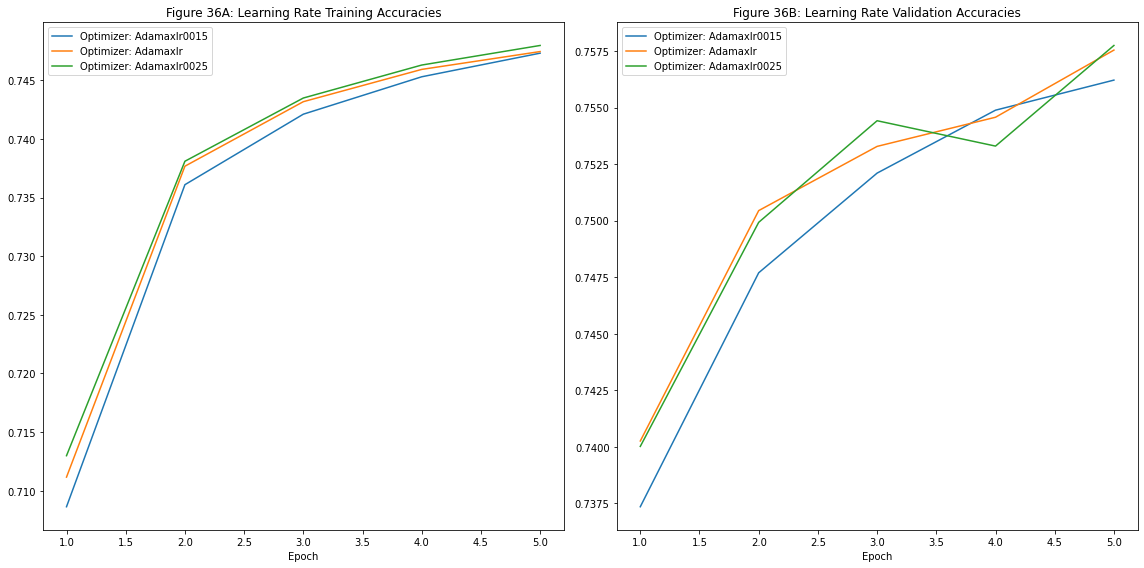

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_lr).plot(title='Figure 36A: Learning Rate Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_lr).plot(title='Figure 36B: Learning Rate Validation Accuracies', ax=axes[1])
plt.tight_layout()

Figure 36: We can see the learning rate stayed consistently strong with the accuracy on the validation set. 

#### Epsilon Search

We are going to see if we can improve upon the default of 1e-8 to improve our validation accuracy.

In [ ]:
hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
    kernel_initializers=best_kernel_initializer
)

optimizers = dict(
    Adamaxeps0005=keras.optimizers.Adamax(epsilon=0.000000005),
    Adamaxeps=keras.optimizers.Adamax(),
    Adamaxeps0015=keras.optimizers.Adamax(epsilon=0.000000015),
    Adamaxeps0020=keras.optimizers.Adamax(epsilon=0.00000002),
)

trainAcc_eps = {}
valAcc_eps = {}

for optimizer_name in optimizers:
    title = "Optimizer: %s" % optimizer_name
    print(optimizer_name)
    
    model = net(**hparam, optimizer=optimizers[optimizer_name])
    result = train(model, batch_size=best_batch_size, epochs=5)
    trainAcc_eps[title] = result['accuracy']
    valAcc_eps[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Adamaxeps0005
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5540 - accuracy: 0.7114 - val_loss: 0.5142 - val_accuracy: 0.7409
Epoch 2/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5188 - accuracy: 0.7381 - val_loss: 0.5025 - val_accuracy: 0.7493
Epoch 3/5
9450000/9450000 [==============================] - 60s 6us/step - loss: 0.5111 - accuracy: 0.7432 - val_loss: 0.4958 - val_accuracy: 0.7532
Epoch 4/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5074 - accuracy: 0.7459 - val_loss: 0.4948 - val_accuracy: 0.7544
Epoch 5/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5048 - accuracy: 0.7475 - val_loss: 0.4916 - val_accuracy: 0.7566
Test Dataset : {'RocAuc': '0.7562', 'Accuracy': '0.7574', 'Precision': '0.7676', 'Recall': '0.7765', 'F1': '0.7720'}
Adamaxeps
Train on 9450000 samples, validate on 1050000 samples
E

#### Epsilon Search Results

The epsilon value of 1.5e-8 performed the best with a combination of training accuracy of 0.7482 and validation accuracy of 0.7574.

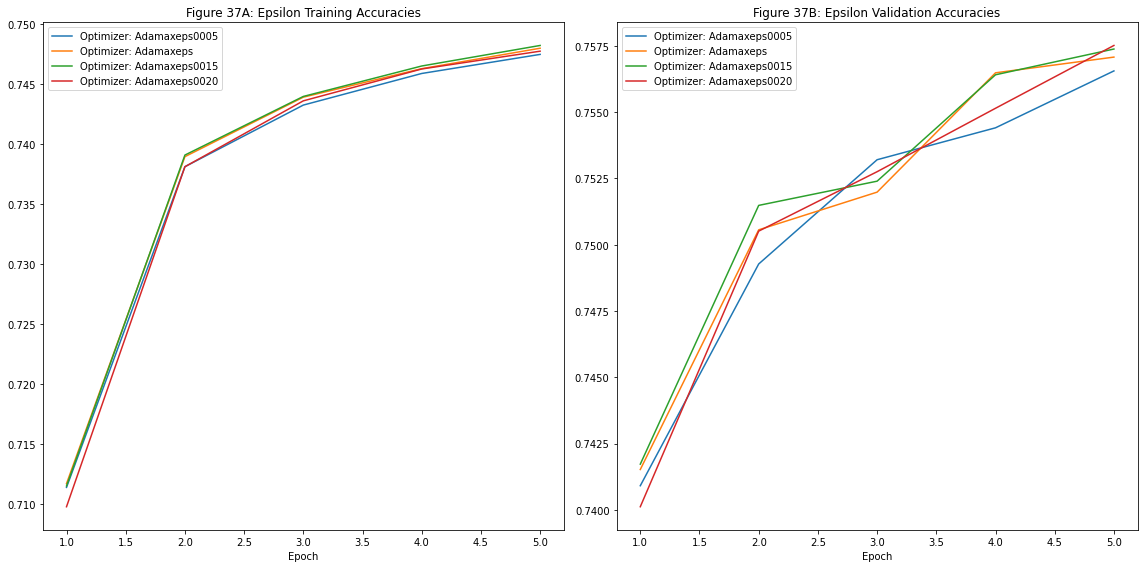

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_eps).plot(title='Figure 37A: Epsilon Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_eps).plot(title='Figure 37B: Epsilon Validation Accuracies', ax=axes[1])
plt.tight_layout()

#### Figure 37, we can see how the 1.5 epsilon valide had a slightly stronger performance with accuracy on the epochs over time.

#### Decay Search

The decay learning rate value of 0 is changed to evaluate if the validation accuracy is improved. 

In [ ]:
hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
    kernel_initializers=best_kernel_initializer
)

optimizers = dict(
    Adamaxde000001=keras.optimizers.Adamax(epsilon=0.000000015,decay=0.000001),
    Adamaxde00001=keras.optimizers.Adamax(epsilon=0.000000015,decay=0.00001),
    Adamaxde0001=keras.optimizers.Adamax(epsilon=0.000000015,decay=0.0001)
)

trainAcc_de = {}
valAcc_de = {}

for optimizer_name in optimizers:
    title = "Optimizer: %s" % optimizer_name
    print(optimizer_name)
    
    model = net(**hparam, optimizer=optimizers[optimizer_name])
    result = train(model, batch_size=best_batch_size, epochs=5)
    trainAcc_de[title] = result['accuracy']
    valAcc_de[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Adamaxde000001
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5543 - accuracy: 0.7110 - val_loss: 0.5144 - val_accuracy: 0.7414
Epoch 2/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5188 - accuracy: 0.7377 - val_loss: 0.5008 - val_accuracy: 0.7503
Epoch 3/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5112 - accuracy: 0.7430 - val_loss: 0.4981 - val_accuracy: 0.7519
Epoch 4/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5072 - accuracy: 0.7457 - val_loss: 0.4922 - val_accuracy: 0.7558
Epoch 5/5
9450000/9450000 [==============================] - 59s 6us/step - loss: 0.5047 - accuracy: 0.7474 - val_loss: 0.4905 - val_accuracy: 0.7566
Test Dataset : {'RocAuc': '0.7566', 'Accuracy': '0.7572', 'Precision': '0.7724', 'Recall': '0.7671', 'F1': '0.7698'}
Adamaxde00001
Train on 9450000 samples, validate on 1050000 samp

#### Decay Search Results

The lowest decay search figure was the strongest with the greatest training and validation accuracy. 

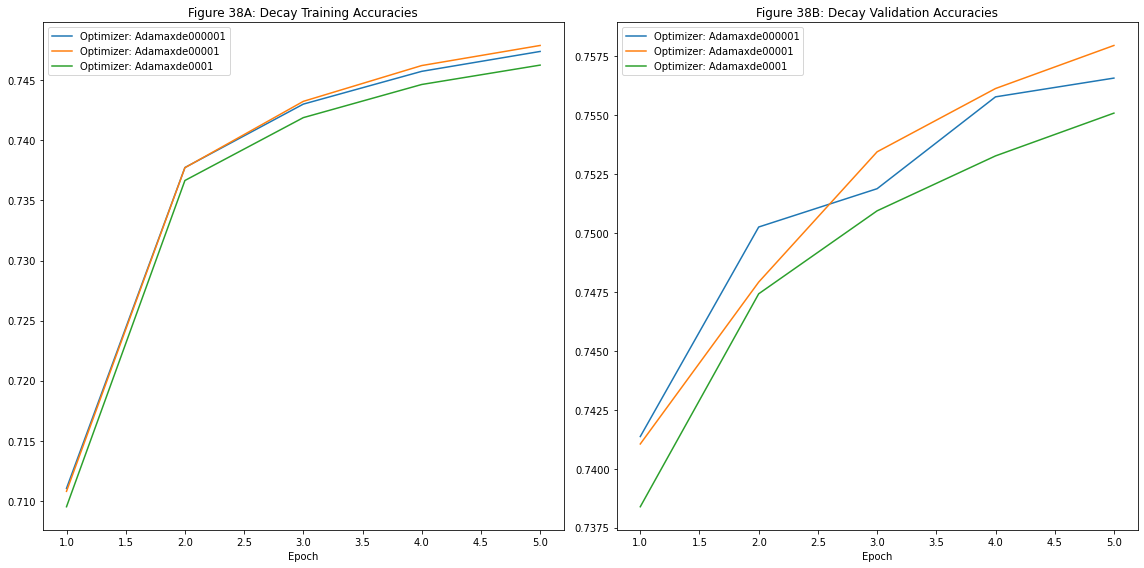

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_de).plot(title='Figure 38A: Decay Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_de).plot(title='Figure 38B: Decay Validation Accuracies', ax=axes[1])
plt.tight_layout()

Figure 38: The decay in learning rate should should be as close to 0 as possible because the validation accuracy tends to increase with epochs. 

#### Dropout Search


We are going to test alternative dropouts of 0.1 to explore how validation accuracy can be improved upon. 

In [ ]:
hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
    kernel_initializers=best_kernel_initializer
)

optimizer = keras.optimizers.Adamax(epsilon=0.000000015)

dropouts = dict(
    dropout1 = 1,
    dropout01 = 0.01,
    dropout001 = 0.001,
    dropout0001 = 0.0001,
    dropout00001 = 0.00001,
    dropout000001 = 0.000001,
    dropout0000001 = 0.0000001,
)

trainAcc_do = {}
valAcc_do = {}

for dropout_name in dropouts:
    title = "Optimizer: %s" % dropout_name
    print(dropout_name)
    
    model = net(**hparam, optimizer=optimizer, dropouts = dropouts[dropout_name])
    result = train(model, batch_size=best_batch_size, epochs=10)
    trainAcc_do[title] = result['accuracy']
    valAcc_do[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

dropout1
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/10
9450000/9450000 [==============================] - 54s 6us/step - loss: 0.5465 - accuracy: 0.7166 - val_loss: 0.5094 - val_accuracy: 0.7435
Epoch 2/10
9450000/9450000 [==============================] - 53s 6us/step - loss: 0.5012 - accuracy: 0.7495 - val_loss: 0.4946 - val_accuracy: 0.7537
Epoch 3/10
9450000/9450000 [==============================] - 54s 6us/step - loss: 0.4915 - accuracy: 0.7557 - val_loss: 0.4879 - val_accuracy: 0.7577
Epoch 4/10
9450000/9450000 [==============================] - 53s 6us/step - loss: 0.4862 - accuracy: 0.7591 - val_loss: 0.4852 - val_accuracy: 0.7602
Epoch 5/10
9450000/9450000 [==============================] - 53s 6us/step - loss: 0.4825 - accuracy: 0.7616 - val_loss: 0.4809 - val_accuracy: 0.7626
Epoch 6/10
9450000/9450000 [==============================] - 53s 6us/step - loss: 0.4799 - accuracy: 0.7634 - val_loss: 0.4816 - val_accuracy: 0.7622
Epoch 7/10
9450000/9450000 [===

#### Dropout Search Results

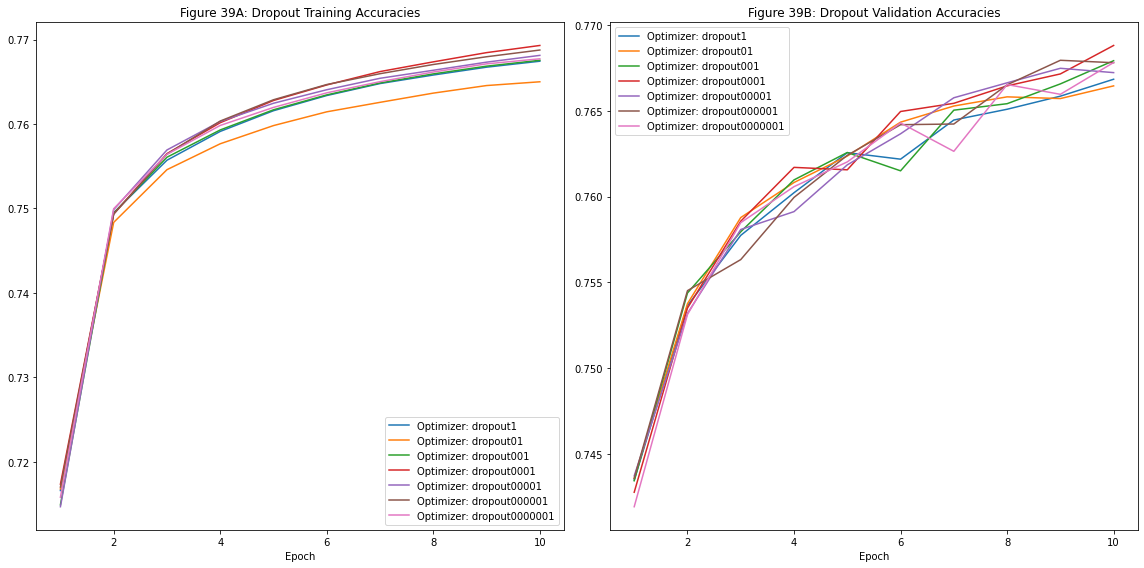

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_do).plot(title='Figure 39A: Dropout Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_do).plot(title='Figure 39B: Dropout Validation Accuracies', ax=axes[1])
plt.tight_layout()

Here we can see a case where changing the drop out rate creates an overfit model where the validation accuracy depends on the runtime session. [Figure 39].

#### Best Shot Parameters

We used the following best shot parameters to maximize the accuracy:
* 800 neurons
* 3 Hidden Layers
* Relu Activation
* 1000 Batch Size
* Random Normal Initializer
* Adamax Optimizer
* Epsilon value of 1.5e-8
* Drop out Rate of 0.01

For time, we will use only 5 epochs to minimize computing resources needed.  

In [ ]:
best_n_units = 800

hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
    kernel_initializers=best_kernel_initializer,
    optimizer = keras.optimizers.Adamax(epsilon=0.000000015)
)

dropout = 0.01

model = net(**hparam, dropouts = dropout)
result = train(model, batch_size=best_batch_size, epochs=5, checkpoint=True, patience=5)
print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Train on 9450000 samples, validate on 1050000 samples
Epoch 1/5
9450000/9450000 [==============================] - 113s 12us/step - loss: 0.5179 - accuracy: 0.7376 - val_loss: 0.4862 - val_accuracy: 0.7602
Epoch 2/5
9450000/9450000 [==============================] - 113s 12us/step - loss: 0.4787 - accuracy: 0.7649 - val_loss: 0.4726 - val_accuracy: 0.7687
Epoch 3/5
9450000/9450000 [==============================] - 113s 12us/step - loss: 0.4680 - accuracy: 0.7718 - val_loss: 0.4646 - val_accuracy: 0.7742
Epoch 4/5
9450000/9450000 [==============================] - 113s 12us/step - loss: 0.4612 - accuracy: 0.7762 - val_loss: 0.4583 - val_accuracy: 0.7781
Epoch 5/5
9450000/9450000 [==============================] - 113s 12us/step - loss: 0.4560 - accuracy: 0.7795 - val_loss: 0.4566 - val_accuracy: 0.7799
Test Dataset : {'RocAuc': '0.7796', 'Accuracy': '0.7805', 'Precision': '0.7917', 'Recall': '0.7939', 'F1': '0.7928'}


#### Best Shot Results

Our best model with optimized parameters generated a training accuracy of 0.7795 and validation accuracy of 0.7799, which is demonstrated in figure 40. 

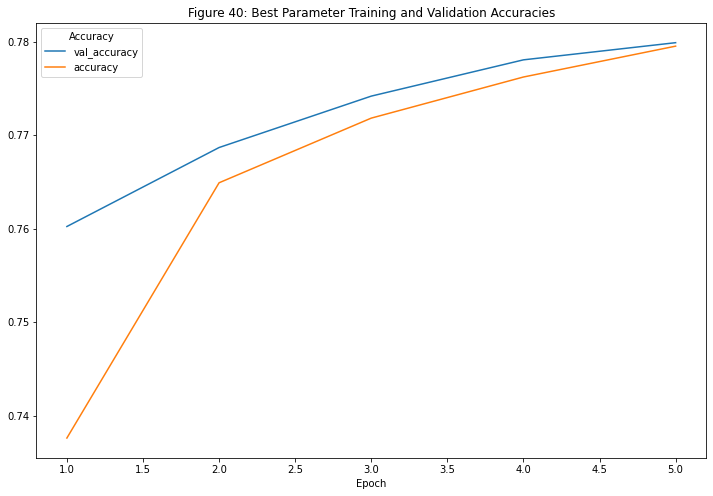

In [ ]:
pd.DataFrame(result).plot(figsize=(12,8), title='Figure 40: Best Parameter Training and Validation Accuracies')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

#model = keras.models.load_model('best.h5')
roc_auc_score(y_test,model.predict(x_test))

0.8653119801449236

## Data Robot
We used our "Best Shot Parameters" and ran two models with 50% and 55% training set respectively while keeping the validation and holdout set constant. 

### Model Blueprint

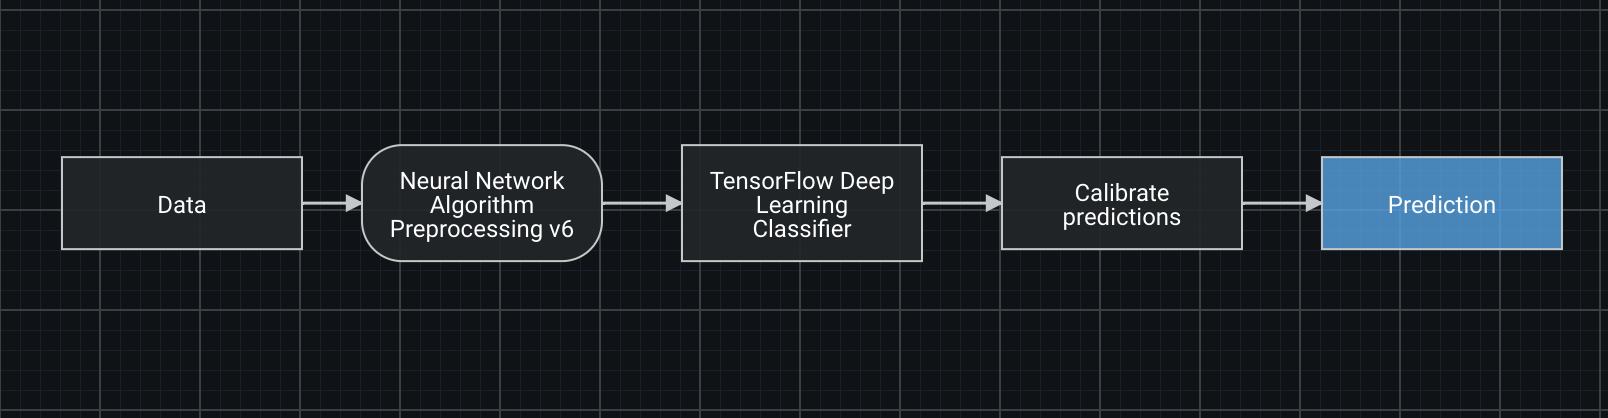

In [ ]:
from IPython.display import Image
Image(filename='Image1.png')

Data Robot provides us a flowchart of their analysis and prediction process. For this program we will be using a Tensor Flow Deep Learning Classifier to create our predictions using the exact same tuning parameters we used above. 

### Lift Chart

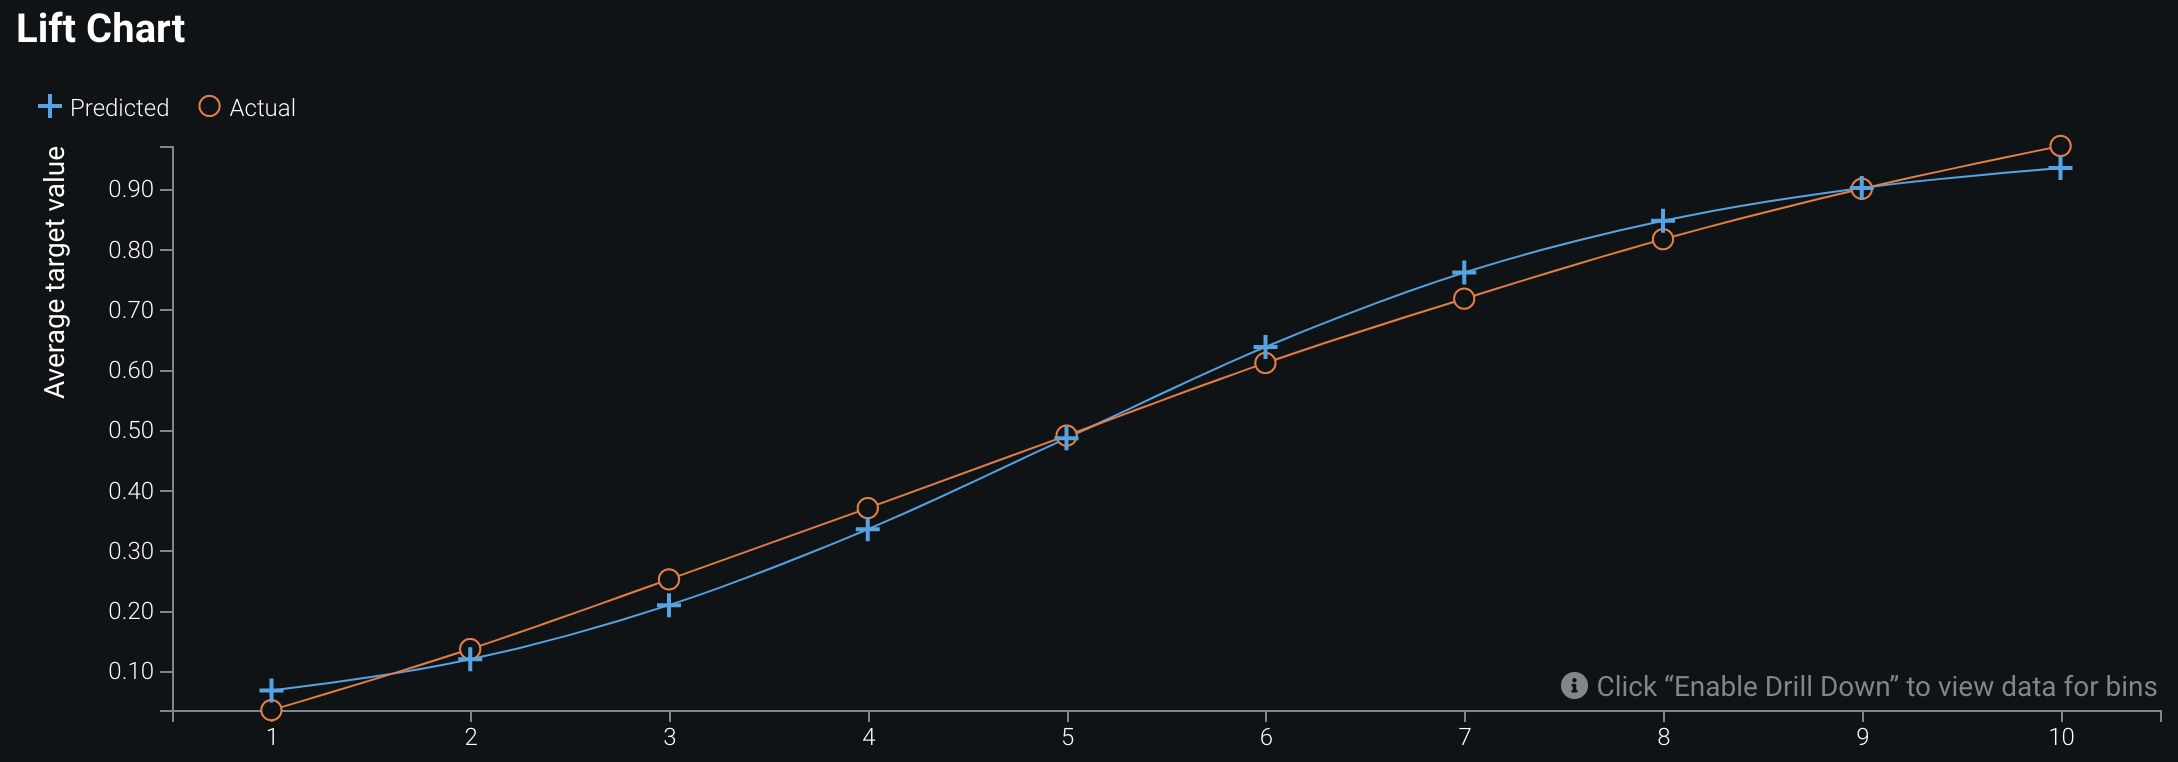

In [ ]:
Image(filename='Image2.png', width = 800, height = 250)

We can see thought the number of processes, we were able to generate a linear trend of predicted values based on the accuracy. If we were to continue beyond 10, we may start to see the predicted values get even closer to the actuals. 

### Model Summary (50%)

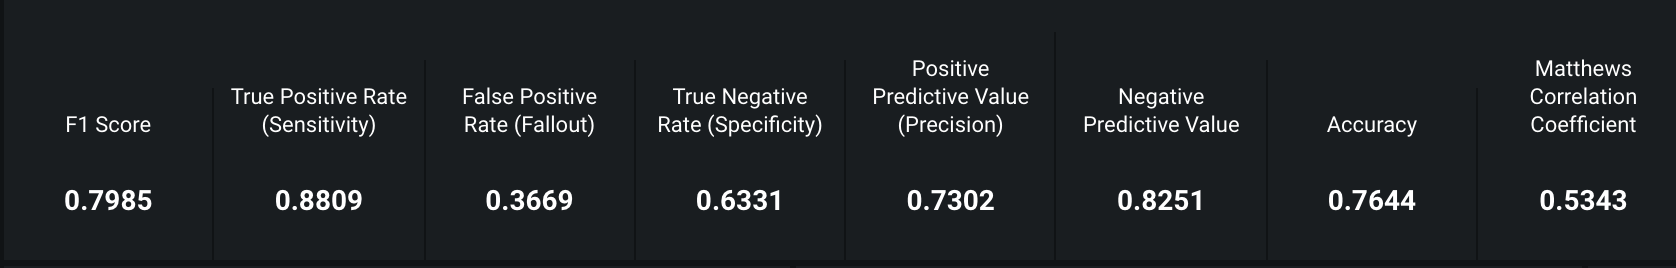

In [ ]:
Image(filename='Image3.png', width = 800, height = 100)

Here, our accuracy score was 0.76 which was lower than our model above, however for our Data Robot model, we used a training set of 50% rather than closer to 95% which was used for the model above. 

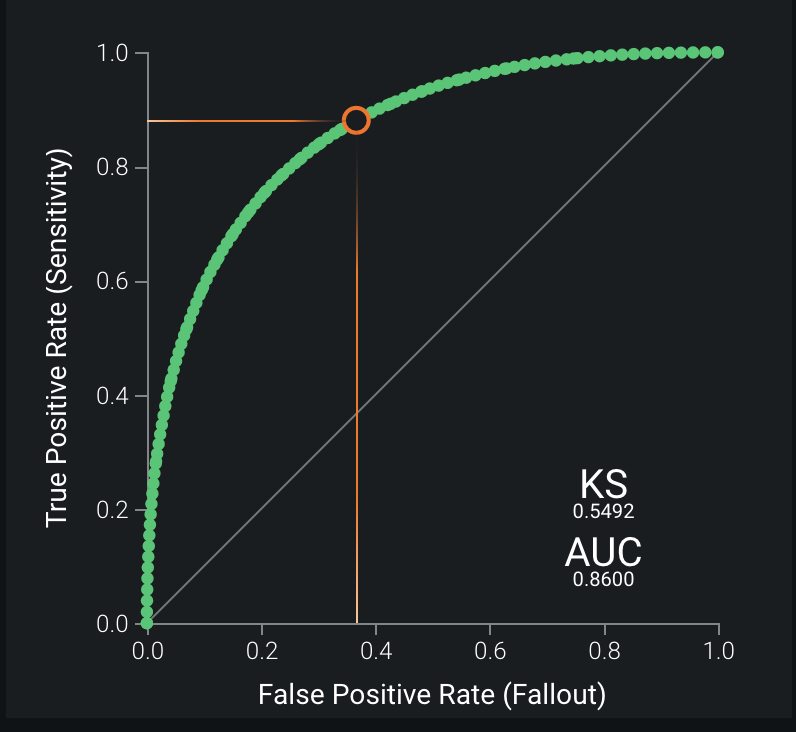

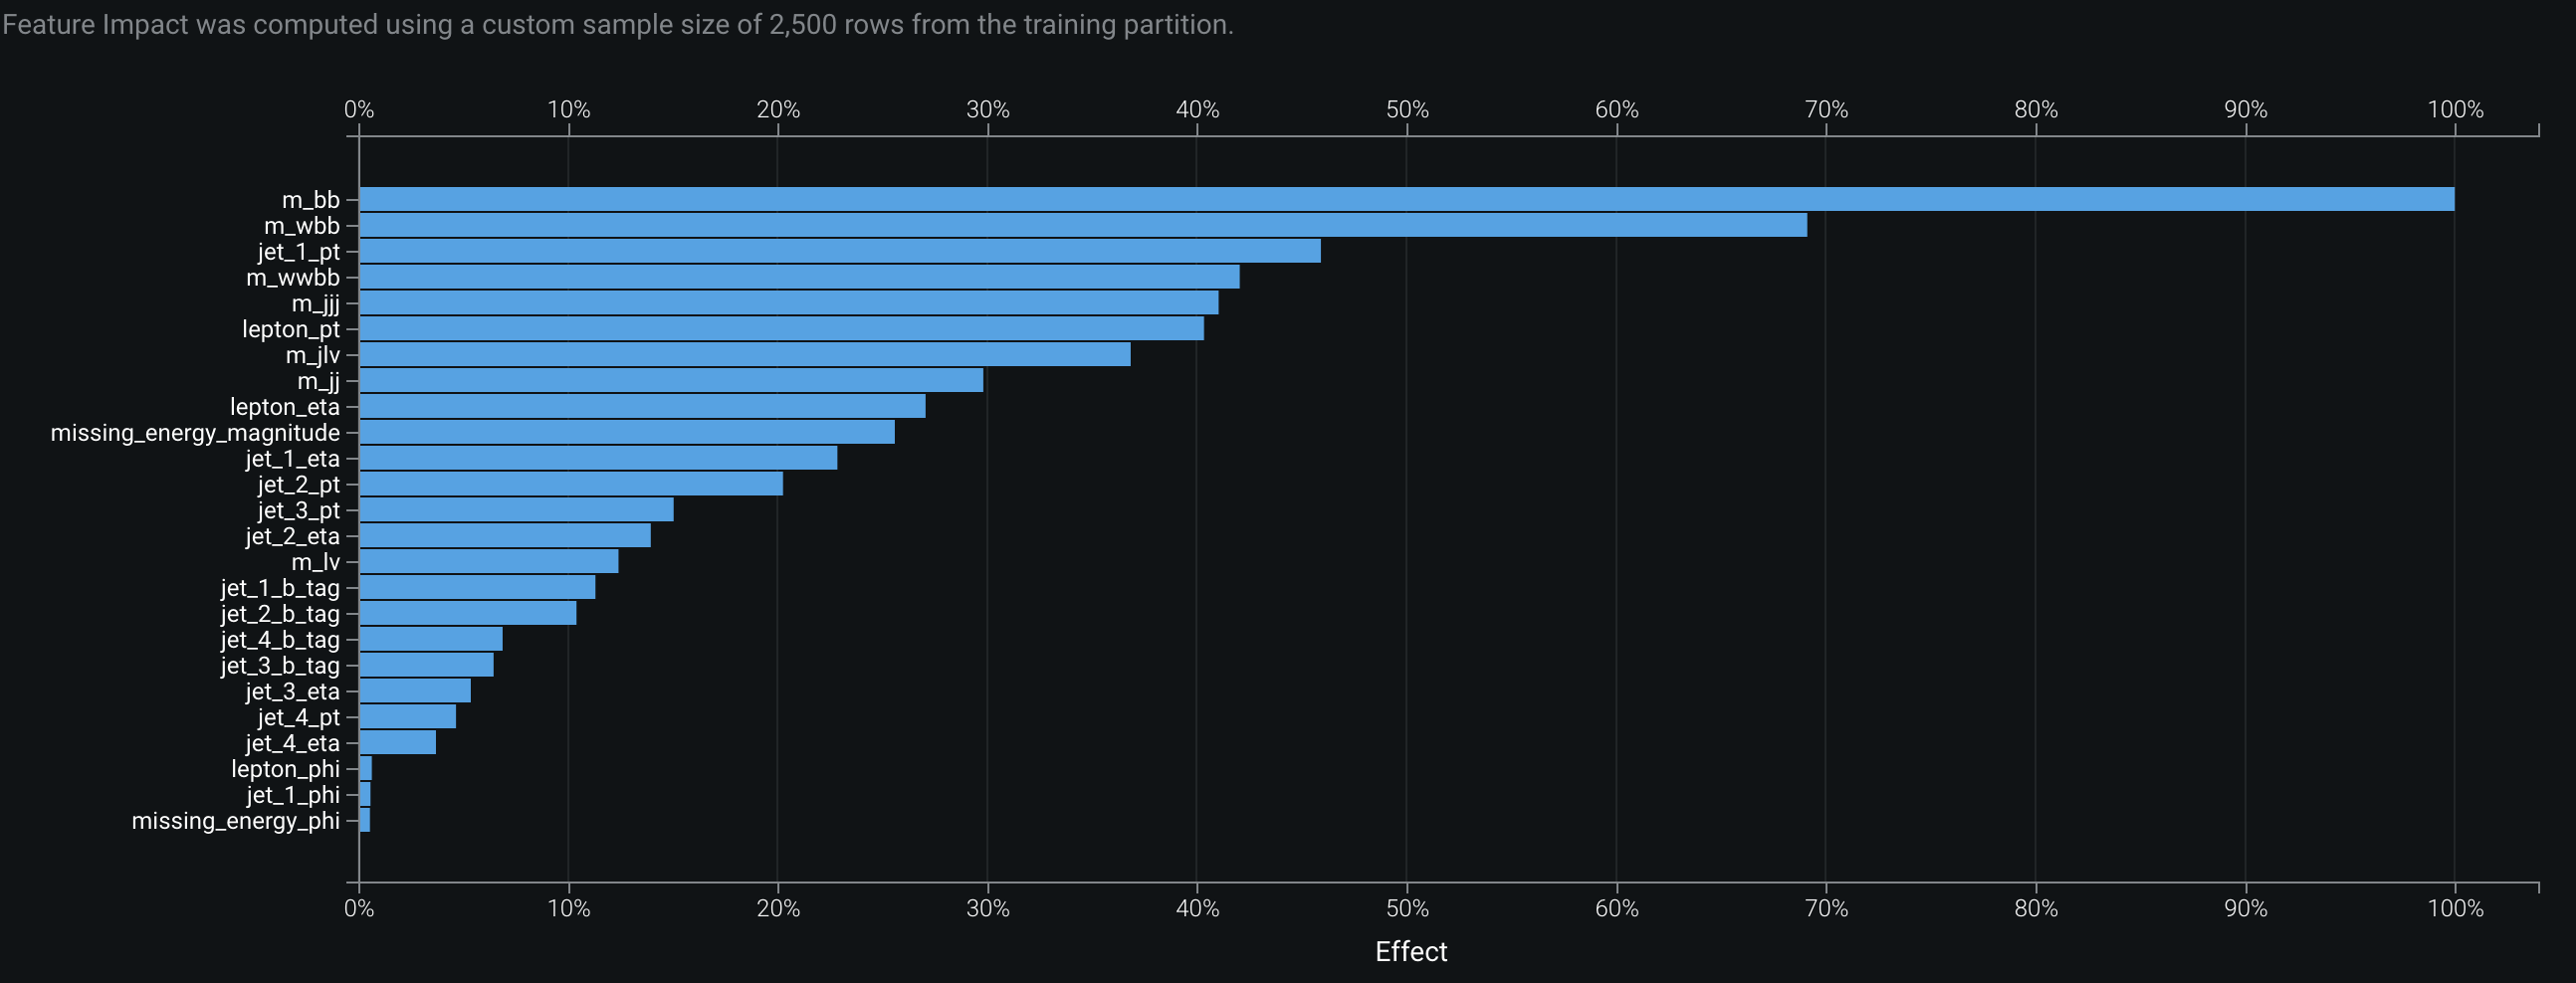

In [ ]:
x = Image(filename='Image6.png', width = 400, height = 100)
y = Image(filename='Image7.png', width = 800, height = 300)
display(x, y)

looking at the feature imporances of our model, we can see that the m_bb and m_wbb both had the greatest impact on the predictability of our classifier. 

### Model Summary (55%)

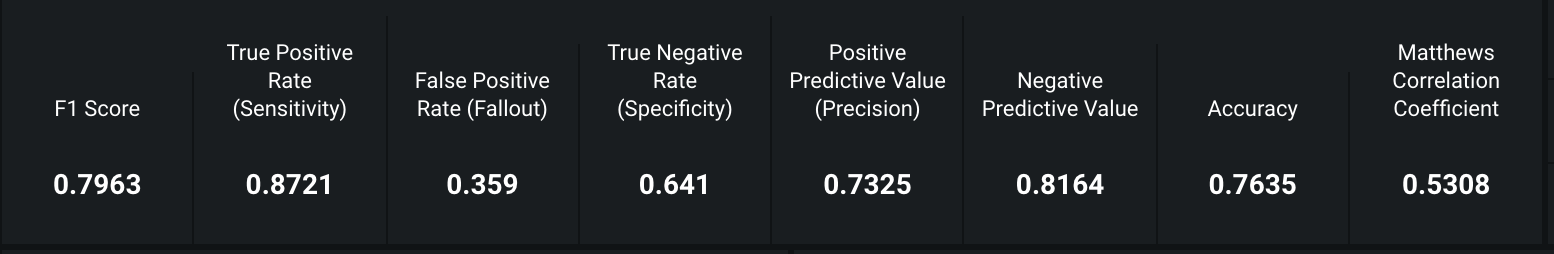

In [ ]:
Image(filename='Image4.png', width = 800, height = 100)

We witnessed marginal decrease in our accuracy when selecting less training set. 

### Q1:How close can you get to the original results

The final result showed an ROC AUC score of 0.86, just short of the 0.88 achieved by Baldi, Sadowski and Whiteson. This was achieved by rigorous testing across all of our hyperparametes. We might have gotten closer if we had ran our final best shot model to more epochs than 5, however, due to time and computing power, we had to limit ourselves. 

### Q2: Any Recommendations or modifications we would make to the approach taken by the researchers. 

We would have explored lower decay searches closer to zero since we are seeing that accuracy improves at 0.000001 and gets lower. 

We would also recommend the use of more modern activation functions (Mish or relu for example), instead of tanh. Plus, we could couple that with more modern optimization using Lookahead and Rectified Adam to solve for cold start issues. 

Additionally, it would be great to explore different grid search combinations of our tuning variables, rather than each in piecemeal to see if we can get better results using different combinations of parameter tunes.

Our model used a GUI based tensorflow program to do the prediction using the winning hyperparameters from our previous model. Using this step, we were also able to capture feature importances to help with deployment. 

### Q3: What are standard practices now vs when the paper was written?

Since we are working with a binary classification problem, we could save a lot of time and effort by automatically testing between different parameter tunes using grid search tools that can be baked directly into the code and done all at once, rather than in piecemeal. 

While this does take computing time, it's much less intensive to code and the grid search tests all combinations of tuning parameters, even if one isn't the best on the default model. This allows for the combination of parameters to have a colinear effect on the performance. 

### Q4: How would you quantify if your result duplicated the papers?

I would look into more detail of the precision and recall metrics garnered from the performance of my model to better understand where I am getting true negatives and false positives in my findings. In the end we replicated the general intent and accuracy of the results of the paper, and are confident that we would achieve or exceed their accuracy given training time. 

References: 

https://www.heatonresearch.com/2017/06/01/hidden-layers.html#:~:text=Traditionally%2C%20neural%20networks%20only%20had,(not%20the%20next%20layer).

https://papers.nips.cc/paper/6372-learning-the-number-of-neurons-in-deep-networks.pdf

https://keras.io/api/layers/initializers/

https://www.thoughtco.com/exponential-decay-definition-2312215#:~:text=In%20mathematics%2C%20exponential%20decay%20describes,of%20time%20that%20has%20passed.